# Emotion Classification with Transfer Learning
By: Michael Chang

* Using **FER-2013** dataset to train our emotion recognition system.
* Using **Convolutional Neural Network** (TensorFlow and Keras) to construct our ML model.
* Using **Computer Vision** (OpenCV) to process test image into a format that allow our model to predict those image's emotion.
* Using **Transfer Learning** (VGG16) to accelerate the learning process of our model.

## Setting up our Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

import os
import cv2
from sklearn.model_selection import RandomizedSearchCV, train_test_split

CLASSES = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')

## Create Function to process data and create our model

* `generators` - Create the training and validation datasets for a given image shape.
* `build_model` - Use a pretrained model to train on X_data, y_data and return the tuned model.
    * We'll use a famous neural network called **VGG16**
        * This network was trained on the ImageNet dataset, containing more than 14 million high-resolution images belonging to 1000 different labels.
    * We can get rid of the default output layer and modify it by adding a few more hidden layers and our custommed output layers (based on `CLASSES`)
    * [Checkout the medium article here](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
    * [Checkout the research paper here](https://arxiv.org/abs/1505.06798)



In [10]:
def generators(shape, preprocessing):
  '''
  Create the training and validation datasets for a given image shape.
  '''
  imgdatagen = ImageDataGenerator(
      preprocessing_function = preprocessing,
      horizontal_flip = True, # data augmentation
      validation_split = 0.2,
  )

  height, width = shape

  train_dataset = imgdatagen.flow_from_directory(
      os.getcwd(),
      target_size = (height, width),
      classes = CLASSES,
      batch_size = batch_size,
      subset = 'training',
      class_mode = "sparse"
  )

  val_dataset = imgdatagen.flow_from_directory(
      os.getcwd(),
      target_size = (height, width),
      classes = CLASSES,
      batch_size = batch_size,
      subset = 'validation',
      class_mode = "sparse"
  )

  return train_dataset, val_dataset


def build_model(n_hidden=1, n_neurons=100, learning_rate=0.005, activation="sigmoid", dropout_rate=0.0):
  """
  Use a pretrained model to train on X_data, y_data and return the tuned model.
  """
  # Initialize our VGG16 imagenet
  conv_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

  for layer in conv_model.layers:
    layer.trainable = False

  # Initialize our neural network
  model = Sequential()

  # Add our VGG16 into the network
  model.add(conv_model)
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(BatchNormalization())

  # Adding hidden layers
  for layer in range(n_hidden):
    model.add(Dense(n_neurons, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))

  model.add(Dense(n_neurons, kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation(activation))

  # Adding output layer
  model.add(Dense(len(CLASSES), activation='softmax'))

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])

  return model

## Preparing our Dataset

### Training Dataset

* Using [FER-2013 Dataset](https://www.kaggle.com/datasets/msambare/fer2013) from Kaggle because it provides images for each basic emotions. 

Angry | Disgust | Fear
-- | -- | --
![angry](A3-Data/Fer2013/images/angry/Training_1021836.jpg) | ![disgust](A3-Data/Fer2013/images/disgust/Training_10371709.jpg) | ![fear](A3-Data/Fer2013/images/fear/Training_1044537.jpg)

Happy | Neutral | Sad | Surprise
-- | -- | -- | --
![happy](A3-Data/Fer2013/images/happy/Training_1018317.jpg) | ![neutral](A3-Data/Fer2013/images/neutral/Training_1017299.jpg) | ![sad](A3-Data/Fer2013/images/sad/Training_1015213.jpg) | ![surprise](A3-Data/Fer2013/images/surprise/Training_1002457.jpg)

### Testing Dataset

* Using images of Pheobe from F.R.I.E.N.D.S

![test1](A3-Data/Phoebe/images/unknown/10_51.jpg) | ![test2](A3-Data/Phoebe/images/unknown/1_01.jpg) | ![test3](A3-Data/Phoebe/images/unknown/11_01.jpg)
-- | -- | --

In [4]:
# Define and move to dataset directory
datasetdir = 'A3-Data/Fer2013/images'
os.chdir(datasetdir)
batch_size = 1

## Train our Model

In [12]:
# Use this block to train a single model with specified parameters
train_dataset, val_dataset = generators((48, 48), preprocessing=keras.applications.vgg16.preprocess_input)

model = build_model(n_hidden=4, n_neurons=1000, learning_rate=0.007, activation="relu", dropout_rate=0.3)
# model = build_model(n_hidden=1, n_neurons=500, learning_rate=0.01, activation="relu", dropout_rate=0.6)
# parameter: weight (set during training)
# hyper parameter: number of hidden layers, (set b4 training)

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    workers = -1,
    epochs = 150,
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
)

Found 840 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Epoch 1/20
840/840 [==============================] - 622s 736ms/step - loss: 36.0727 - acc: 0.1845 - val_loss: 2.2915 - val_acc: 0.1762
Epoch 2/20
840/840 [==============================] - 681s 811ms/step - loss: 5.8403 - acc: 0.1774 - val_loss: 2.1141 - val_acc: 0.1810
Epoch 3/20
840/840 [==============================] - 561s 667ms/step - loss: 2.4373 - acc: 0.1786 - val_loss: 2.0958 - val_acc: 0.1476
Epoch 4/20
840/840 [==============================] - 475s 565ms/step - loss: 2.3593 - acc: 0.1714 - val_loss: 2.2978 - val_acc: 0.1571
Epoch 5/20
840/840 [==============================] - 411s 489ms/step - loss: 2.6589 - acc: 0.1952 - val_loss: 2.1398 - val_acc: 0.1524
Epoch 6/20
840/840 [==============================] - 416s 495ms/step - loss: 2.2356 - acc: 0.1893 - val_loss: 2.0269 - val_acc: 0.1524
Epoch 7/20
840/840 [==============================] - 515s 613ms/step - loss: 2.1918 - acc: 0.1774 - 

In [13]:
# Save our model in .h5 file
model.save('emotion_detection_model.h5')

In [2]:
# Accessing the pre-trained model
# MODEL_PATH = "emotion_detection_model.h5"
MODEL_PATH = "emotion_recognition.h5"
model = keras.models.load_model(MODEL_PATH)

## Test out our Model

* Using our pre-trained model to classify the test images
* Using OpenCV to format those image in a way that allow the model to process and predict the result.

In [3]:
def classify_emotion(image):
  """
  Used our ML model to predict emotion, and return a tensor
  """
  output_tensor = model((np.array([image])))
  return output_tensor

def get_image(filename):
  """
  Create a shortcut to access the image
  """
  return f"A3-Data/Phoebe/images/unknown/{filename}"

def get_outcome(image):
  """
  Convert input image into a readable format to allow our ML model to predict the emotion.
  """
  image_link = get_image(image)
  image_file = open(f"{image_link}", "rb")
  input_file = image_file.read()
  numpy_image = np.fromstring(input_file, np.uint8)
  decoded_image = cv2.imdecode(numpy_image, cv2.IMREAD_COLOR)
  cvt_color_image = cv2.cvtColor(decoded_image, cv2.COLOR_BGR2RGB)
  input_image = cv2.resize(cvt_color_image, (48, 48))
  # input_image = cv2.resize(cvt_color_image, (224, 224))
  output_tensor = classify_emotion(input_image)
  output_list = output_tensor[0].numpy().tolist()
  
  return output_list

/Users/michaelchang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


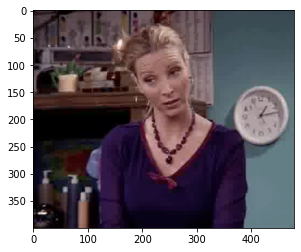

angry: 1.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 0.0


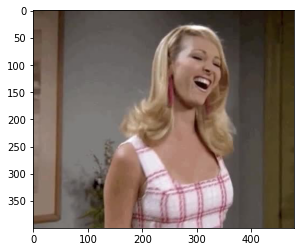

angry: 0.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 1.0


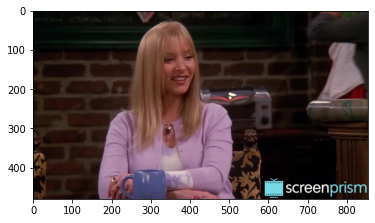

angry: 0.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 1.0


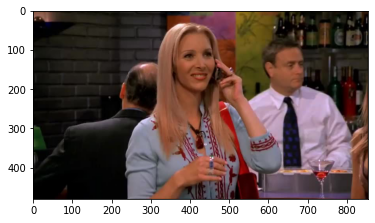

angry: 0.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 1.0


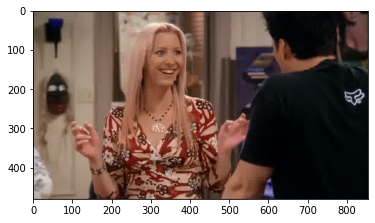

angry: 1.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 0.0


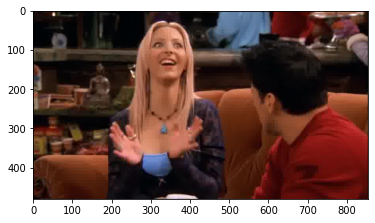

angry: 0.0
disgust: 0.0
fear: 0.0
happy: 1.0
neutral: 0.0
sad: 0.0
surprise: 1.7208365860886703e-26


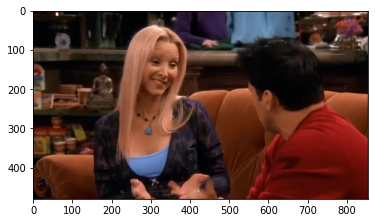

angry: 0.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 1.0


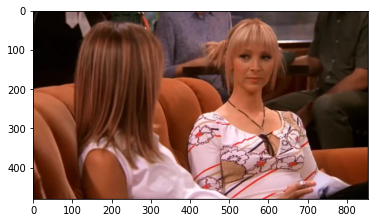

angry: 0.0
disgust: 0.0
fear: 0.0
happy: 0.0
neutral: 0.0
sad: 0.0
surprise: 1.0


In [4]:
image_list = ["52_31.jpg", "41_06.jpg", "19_02.jpg", "11_01.jpg", "10_51.jpg", "9_41.jpg", "8_01.jpg", "1_01.jpg"]

for image in image_list:
  output_list = get_outcome(image)

  img_link = get_image(image)
  temp_img = img.imread(img_link)
  plt.imshow(temp_img)
  plt.show()

  for current_class, probability in zip(CLASSES, output_list):
    print(f"{current_class}: {probability}")